<a href="https://colab.research.google.com/github/albogdan/aps360-project/blob/master/baseline_models/CNN/CNN_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchsummary import summary
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if os.path.exists(os.path.expanduser('~/data')):
  !rm -rf {os.path.expanduser('~/data')}
!unzip '/content/drive/My Drive/APS360 Project/kaggle_dataset/separate_dataset.zip' -d {os.path.expanduser('~/data')}

In [4]:
classes = os.listdir(os.path.expanduser('~/data/separate_dataset'))
classes.sort()
classes = classes[1:]
print(classes)

['14719', '15672', '18654', '2357', '2420', '2780', '27925', '3001', '3002', '3003', '3004', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3037', '3038', '3039', '3040', '3045', '3046', '3062', '3063', '3068', '3069', '3070', '3298', '33909', '3622', '3623', '3659', '3675', '3700', '3794', '4150', '41677', '41678', '4274', '4286', '43093', '43857', '4490', '54200', '6143', '6632', '85984', '99301']


In [5]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((224,224)), 
                                     transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 32

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data/separate_dataset'), transform=data_transform)

In [6]:
# function to load features
def image_loader(dataset, train_p, val_p, batch_size = 32):
  split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
  split.append(len(dataset) - split[1] - split[0])

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
  num_workers = 4

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  return train_loader, val_loader, test_loader

#Architecture

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#Training Code

In [8]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <-- 
    train_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size,
                                             num_workers = 4, shuffle = True)
    outputs = []
    start_time = time.time()
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            if torch.cuda.is_available():
              img = img.cuda()
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

#Training

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
model = Autoencoder().cuda()
max_epochs = 20
outputs = train(model, num_epochs=max_epoc hs, batch_size=500)

Epoch 0 Finished.  Time per Epoch:  137.14 s 
Epoch:1, Loss:0.0025
Epoch 1 Finished.  Time per Epoch:  137.63 s 
Epoch:2, Loss:0.0012
Epoch 2 Finished.  Time per Epoch:  137.70 s 
Epoch:3, Loss:0.0009
Epoch 3 Finished.  Time per Epoch:  137.99 s 
Epoch:4, Loss:0.0006
Epoch 4 Finished.  Time per Epoch:  137.78 s 
Epoch:5, Loss:0.0005
Epoch 5 Finished.  Time per Epoch:  137.88 s 
Epoch:6, Loss:0.0003
Epoch 6 Finished.  Time per Epoch:  137.90 s 
Epoch:7, Loss:0.0003
Epoch 7 Finished.  Time per Epoch:  137.84 s 
Epoch:8, Loss:0.0003
Epoch 8 Finished.  Time per Epoch:  137.90 s 
Epoch:9, Loss:0.0003
Epoch 9 Finished.  Time per Epoch:  137.95 s 
Epoch:10, Loss:0.0003
Epoch 10 Finished.  Time per Epoch:  138.01 s 
Epoch:11, Loss:0.0003
Epoch 11 Finished.  Time per Epoch:  137.94 s 
Epoch:12, Loss:0.0002
Epoch 12 Finished.  Time per Epoch:  137.92 s 
Epoch:13, Loss:0.0002
Epoch 13 Finished.  Time per Epoch:  137.90 s 
Epoch:14, Loss:0.0002
Epoch 14 Finished.  Time per Epoch:  137.95 s 
Epoch:

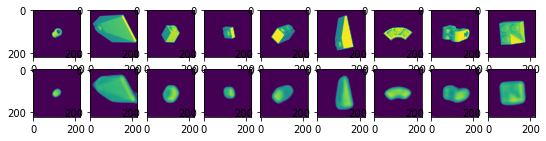

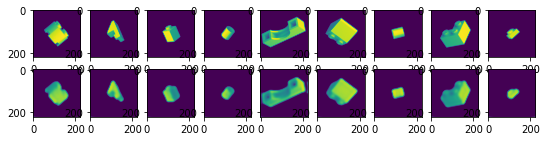

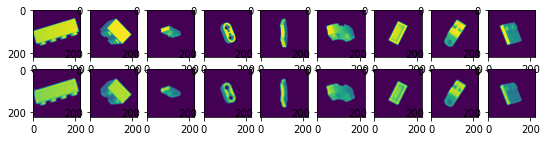

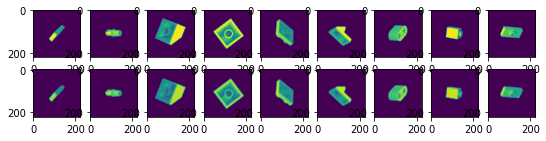

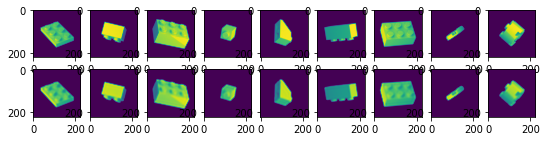

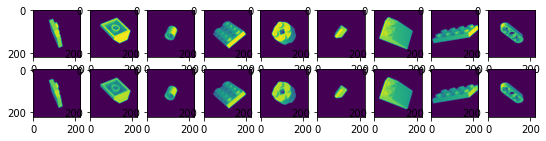

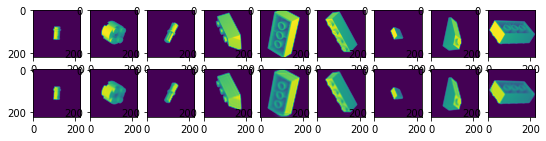

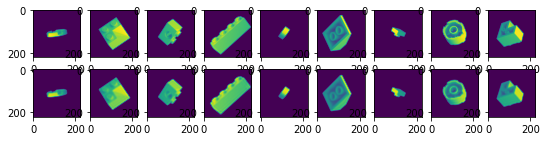

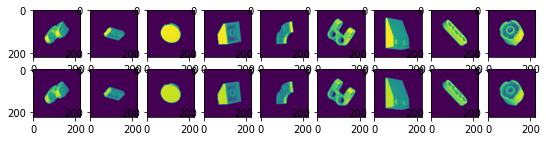

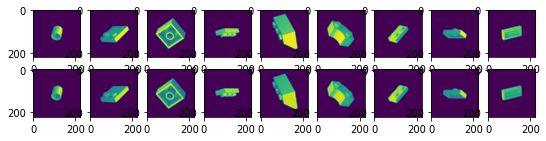

In [ ]:
for k in range(0, max_epochs, 2):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

#Training with Noise

In [9]:
def train_noise(model, num_epochs=5, batch_size=64, learning_rate=1e-3, noise = 0):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <-- 
    train_loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size,
                                             num_workers = 4, shuffle = True)
    outputs = []
    start_time = time.time()
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img_noisy = img + noise * torch.randn(*img.shape)
            img_noisy = np.clip(img_noisy, 0., 1.)
            if torch.cuda.is_available():
              img_noisy = img_noisy.cuda()
              img = img.cuda()
            recon = model(img_noisy)
            # recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [ ]:
model_2 = Autoencoder().cuda()
max_epochs = 20
outputs = train_noise(model_2, num_epochs=max_epochs, batch_size=300, learning_rate=1e-3, noise = 1e-3)

Epoch 0 Finished.  Time per Epoch:  172.10 s 
Epoch:1, Loss:0.0021
Epoch 1 Finished.  Time per Epoch:  172.37 s 
Epoch:2, Loss:0.0006
Epoch 2 Finished.  Time per Epoch:  172.74 s 
Epoch:3, Loss:0.0004
Epoch 3 Finished.  Time per Epoch:  173.07 s 
Epoch:4, Loss:0.0003
Epoch 4 Finished.  Time per Epoch:  173.45 s 
Epoch:5, Loss:0.0002
Epoch 5 Finished.  Time per Epoch:  173.66 s 
Epoch:6, Loss:0.0002
Epoch 6 Finished.  Time per Epoch:  173.81 s 
Epoch:7, Loss:0.0002
Epoch 7 Finished.  Time per Epoch:  173.83 s 
Epoch:8, Loss:0.0002
Epoch 8 Finished.  Time per Epoch:  173.81 s 
Epoch:9, Loss:0.0002
Epoch 9 Finished.  Time per Epoch:  173.76 s 
Epoch:10, Loss:0.0002
Epoch 10 Finished.  Time per Epoch:  173.75 s 
Epoch:11, Loss:0.0002
Epoch 11 Finished.  Time per Epoch:  173.73 s 
Epoch:12, Loss:0.0002
Epoch 12 Finished.  Time per Epoch:  173.72 s 
Epoch:13, Loss:0.0001
Epoch 13 Finished.  Time per Epoch:  173.70 s 
Epoch:14, Loss:0.0001
Epoch 14 Finished.  Time per Epoch:  173.70 s 
Epoch:

In [3]:
torch.save(model_2.state_dict(), os.pacth.expanduser('~/noise1'))

NameError: ignored

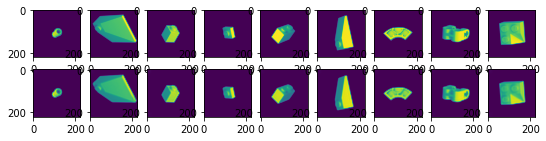

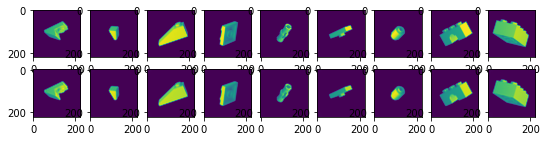

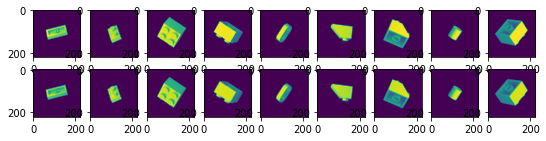

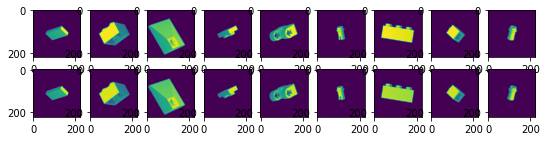

In [ ]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [ ]:
torch.cuda.empty_cache()
model_3 = Autoencoder()
model_3 = model_3.cuda()
max_epochs = 20
outputs_temp = train_noise(model_3, num_epochs=max_epochs, batch_size=500, learning_rate=1e-3, noise = 3e-3)

Epoch 0 Finished.  Time per Epoch:  169.54 s 
Epoch:1, Loss:0.0300
Epoch 1 Finished.  Time per Epoch:  169.66 s 
Epoch:2, Loss:0.0306
Epoch 2 Finished.  Time per Epoch:  169.68 s 
Epoch:3, Loss:0.0310
Epoch 3 Finished.  Time per Epoch:  169.73 s 
Epoch:4, Loss:0.0294
Epoch 4 Finished.  Time per Epoch:  169.79 s 
Epoch:5, Loss:0.0312


KeyboardInterrupt: ignored

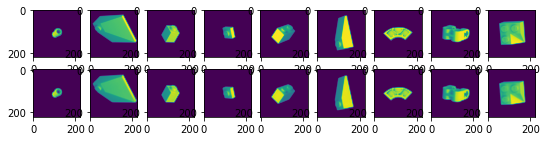

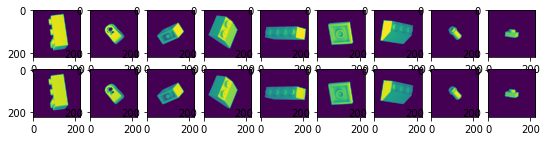

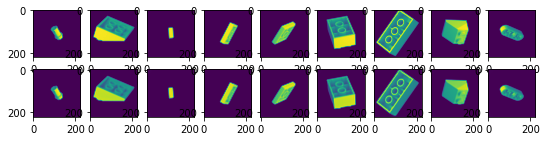

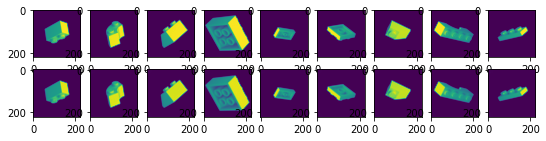

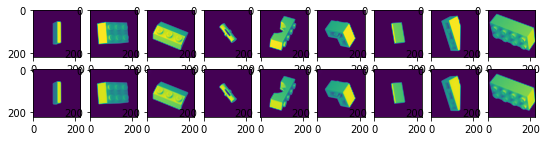

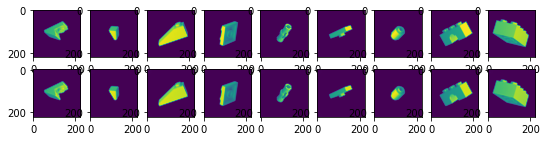

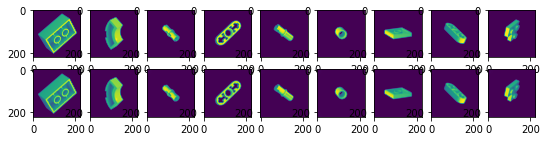

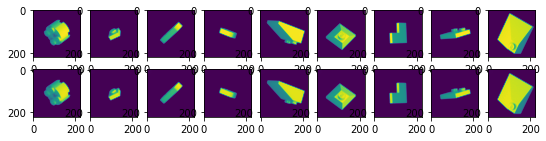

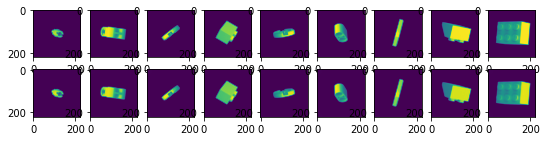

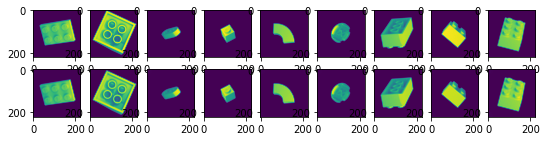

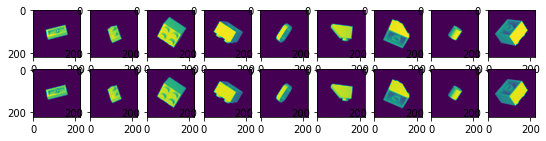

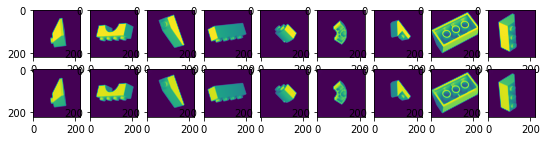

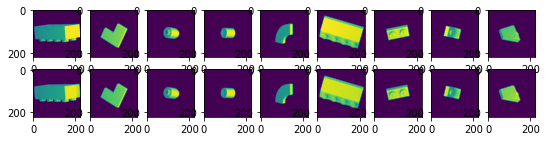

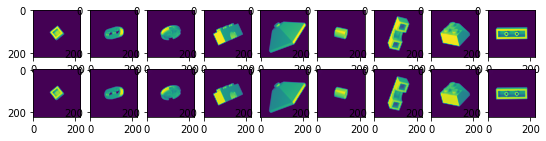

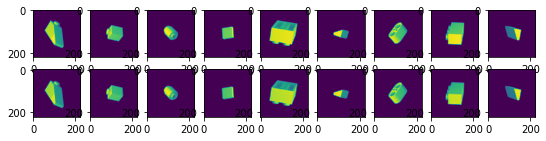

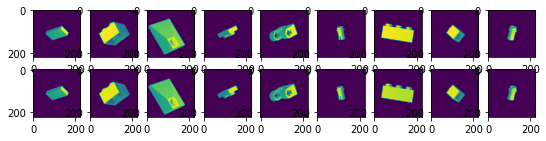

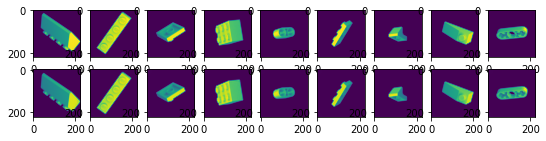

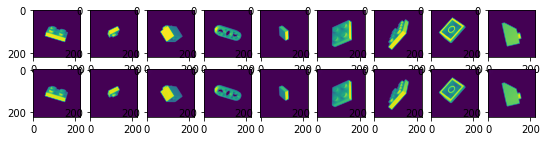

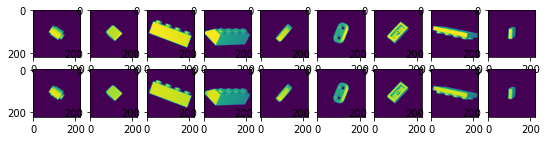

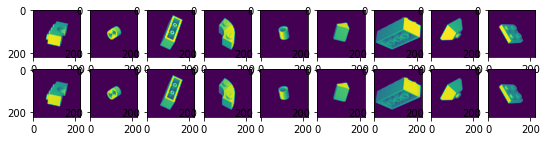

In [ ]:
for k in range(0, max_epochs, 1):
    plt.figure(figsize=(9, 2))
    imgs = outputs_temp[k][1].detach().cpu().numpy()
    recon = outputs_temp[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])